In [16]:
import chainer
from chainer import training, iterators, optimizers, serializers, Chain
import chainer.functions as F
import chainer.links as L
 
from chainer.training import extensions
from chainer.datasets import tuple_dataset
from chainer import optimizers, Chain, dataset, datasets, iterators
import numpy as np

In [17]:
def data_read( file_name, key_data, is_one_hot ):
    teachers = np.array([] )
    answers =  np.array([] )

    f = open( file_name, mode = "r" )

    f_string = f.readlines()

    day_data = np.array([] )
    tmp_data = np.array([] )
    for i in range( 0, len( f_string ) ):
        
        day_data = np.append( day_data, float(f_string[i].replace( "\n", "" )))
        
        # 一日のデータを格納する
        if( (i+1)%6 == 0 and i != 0 ):
            # 引数を軸にデータを教師データと正解ラベルに振り分ける
            if( (i+1)//6%key_data == 0):
                # 正解ラベルは終値
                teachers = np.append( teachers, tmp_data)
                # 正解ラベルをone hotで表現する場合
                if( is_one_hot ):
                    answers = np.append( answers, tmp_data[6 * (key_data - 1) - 3] > day_data[3])
                else:
                    answers = np.append( answers, day_data[3] )
                tmp_data = np.array([] )
            else:
                tmp_data = np.append( tmp_data, day_data)
                #teachers = np.append( teachers, day_data )
            day_data = np.array([] )
            
    f.close()

    
    #if( len(teachers) != 0 ):
        #teachers[3:-1:6] = scaler.fit_transform(teachers[3:-1:6])
        #xmean = teachers[3:-1:6].mean(axis=1, keepdims=True)
        #xstd  = np.std(teachers[3:-1:6], axis=1, keepdims=True)
        #teachers[3:-1:6] = (x-xmean)/xstd
    teachers = teachers.astype( np.float32 )
    answers = answers.astype( np.float32 )

    #teachers = np.reshape( teachers, ( int( len( teachers ) / 6 ), 6 ) )
    #answers = np.reshape( answers, ( len( answers ) , 1 ) )

    return teachers, answers


In [18]:
def take_data(year, key_day, is_one_hot):
    file = open('nikkei.txt')
    stock_numbers = file.readlines()
    file.close()
    
    teachers = np.array([] )
    answers =  np.array([] )
    
    for number in stock_numbers:
        number = number.rstrip('\n')
        tmp_teacher, tmp_answer = data_read('./data/{}_{}.txt'.format(number, year), key_day, is_one_hot)
        teachers = np.append( teachers, tmp_teacher)
        answers = np.append( answers, tmp_answer)
        
    teachers = teachers.astype( np.float32 )
    answers = answers.astype( np.int32 )

    teachers = np.reshape( teachers, ( int( len( teachers ) / (6 * (key_day-1) ) ), 6 * (key_day-1) ) )
    answers = np.reshape( answers, ( len( answers ) , 1 ) )
    answers = answers.flat[:]

    return teachers, answers

In [19]:
# 何日間のデータで学習させるか
key_data = 6
teachers, answers = take_data(2018, key_data, True)

In [20]:
#ニューラルネットワークの構築。
class MyChain(Chain):
    
    def __init__(self, n_hidden, n_output):
        super(MyChain, self).__init__(
            l1=L.Linear(None, n_hidden),
            l2=L.LSTM(None, n_hidden),
            l3=L.Linear(None, n_output),
        )
        
    def reset_state(self):
        self.l2.reset_state()
        
    def __call__(self, x, t):
        y = self.predict(x)
        loss = F.softmax_cross_entropy(y, t)
        accuracy = F.accuracy(y, t)
        chainer.reporter.report({'accuracy':accuracy},self)
        chainer.reporter.report({'loss':loss},self)
        return loss
    
    def predict(self, x):
        h1 = self.l1(x)
        if train:
            h2 = F.dropout(self.l2(h1),ratio = 0.5)
        else:
            h2 = self.l2(h1)
        return self.l3(h2)

In [21]:
## LSTMUpdaterを作る。
from chainer import Variable, reporter

class LSTMUpdater(training.StandardUpdater):
    def __init__(self, data_iter, optimizer, device=None):
        super(LSTMUpdater,self).__init__(data_iter, optimizer, device=None)
        self.device = device
        
    def update_core(self):
        data_iter = self.get_iterator("main")
        optimizer = self.get_optimizer("main")
        
        batch = data_iter.__next__()
        x_batch, t_batch = chainer.dataset.concat_examples(batch, self.device)
        
        optimizer.target.reset_state()           #追加
        optimizer.target.cleargrads()
        loss = optimizer.target(Variable(x_batch), Variable(t_batch))
        loss.backward()
        loss.unchain_backward()                  #追記
        optimizer.update() 


In [ ]:
#　教師データのtupleを作成する
data = datasets.TupleDataset(teachers, answers)

#総データの長さ
N = len(teachers)

# ログの保存用
results_train = {
    'loss': [],
    'accuracy': []
}
results_valid = {
    'loss': [],
    'accuracy': []
}

n_batchsize = 30
n_epoch = 10000

#モデルを使う準備。オブジェクトを生成
n_hidden = (key_data-1)*6
n_output = 2
model = MyChain(n_hidden, n_output)
optimizer = optimizers.Adam()
optimizer.setup(model)

#学習用データと検証用データに分ける
train, test = chainer.datasets.split_dataset_random(data, int(N * 0.8))
train_iter = chainer.iterators.SerialIterator(train, n_batchsize, shuffle=False)
test_iter = chainer.iterators.SerialIterator(test, n_batchsize, repeat=False, shuffle=False)
updater = LSTMUpdater(train_iter, optimizer, device=-1)
trainer = training.Trainer(updater, (n_epoch, "epoch"), out="result")
trainer.extend(extensions.Evaluator(test_iter, model, device=-1))
trainer.extend(extensions.LogReport(trigger=(10, "epoch"))) # 1エポックごとにログ出力
trainer.extend(extensions.PrintReport( ["epoch", "main/loss", "validation/main/loss", "main/accuracy", "validation/main/accuracy", "elapsed_time"])) # エポック、学習損失、テスト損失、学習正解率、テスト正解率、経過時間
trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
10          0.696575    0.692055              0.515132       0.524571                  12.3219       
20          0.692166    0.693623              0.522502       0.522667                  26.4691       
30          0.691921    0.694141              0.523563       0.522111                  40.34         
40          0.692033    0.693592              0.522194       0.518341                  54.9538       
50          0.692064    0.693674              0.522629       0.516476                  69.2584       
60          0.692026    0.694134              0.523003       0.517087                  83.4127       
70          0.691969    0.694305              0.522516       0.51781                   97.7028       
80          0.691819    0.695598              0.523021       0.517587                  112.043       
90          0.691939    0.696257              0.522974       0.516865               

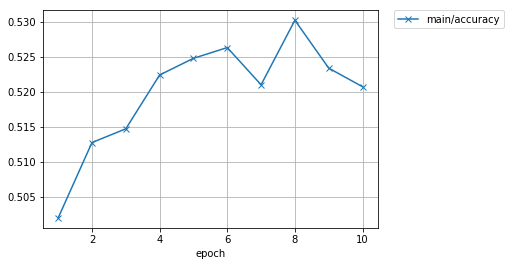

In [42]:
from IPython.display import Image, display_png
display_png(Image("./result/accuracy.png"))

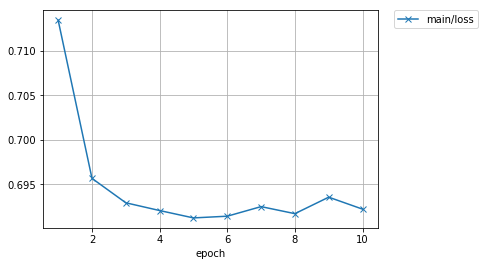

In [43]:
display_png(Image("./result/loss.png"))